In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.signal as signal # For calculating PSDs and plotting spectrograms
from neurodsp.spectral import compute_spectrum # for smoothed PSD computation
from pathlib import Path 

In [2]:
eeg_fs = 250 # Data was recorded at 250 Hz

In [3]:
## Create DF for each of these, columns are channels, each row is a trial run
def getDF(epochs, labels, times, chans):
    data_dict = {}
    for i, label in enumerate(labels): 
        start_time = times[i][0]
        if 'start_time' not in data_dict: 
            data_dict['start_time'] = list()
        data_dict['start_time'].append(start_time)
        
        if 'event_type' not in data_dict:
            data_dict['event_type'] = list()
        data_dict['event_type'].append(label)
        
        for ch in range(len(chans)): 
            if chans[ch] not in data_dict:
                data_dict[chans[ch]] = list() 
            data_dict[chans[ch]].append(epochs[i][ch])
        
    return pd.DataFrame(data_dict)

In [4]:
# Extract data from raw dataframes for constructing trial-by-trial dataframe
def getEpochedDF(eeg_df, event_df, trial_duration_ms=4000):
    epochs = []
    epoch_times = []
    labels = []
    start_df = eeg_df[eeg_df['EventStart'] == 1]
    for i, event_type in enumerate(event_df["EventType"].values): 
        labels.append(event_type)
        start_time = start_df.iloc[i]["time"]
        end_time = int(start_time + trial_duration_ms)
        epoch_times.append((start_time, end_time))
        sub_df = eeg_df[(eeg_df['time'] > start_time) & (eeg_df['time'] <= end_time)]
        eeg_dat = []
        for ch in all_chans: 
            eeg_dat.append(sub_df[ch].values)
        epochs.append(np.array(eeg_dat))

    # Create dataframe from the data extracted previously
    eeg_epoch_df = getDF(epochs, labels, epoch_times, all_chans)
    return eeg_epoch_df

In [5]:
def plotPSD(freq, psd, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120, label=None):
    '''
    Inputs 
    - freq: the list of frequencies corresponding to the PSDs
    - psd: the list of psds that represent the power of each frequency
    - pre_cut_off_freq: the lowerbound of the frequencies to show
    - post_cut_off_freq: the upperbound of the frequencies to show
    - label: a text label to assign this plot (in case multiple plots want to be drawn)
    
    Outputs: 
    - None, except a plot will appear. plot.show() is not called at the end, so you can call this again to plot on the same axes. 
    '''
    # Label the axes
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log(PSD)')
    
    # Calculate the frequency point that corresponds with the desired cut off frequencies
    pre_cut = int(len(freq)*(pre_cut_off_freq / freq[-1]))
    post_cut = int(len(freq)*(post_cut_off_freq / freq[-1]))
    
    # Plot
    plt.plot(freq[pre_cut:post_cut], np.log(psd[pre_cut:post_cut]), label=label)

# Get Frequencies and PSDs from EEG data - this is the raw PSD method. 
def getFreqPSDFromEEG(eeg_data, fs=eeg_fs):
    # Use scipy's signal.periodogram to do the conversion to PSDs
    freq, psd = signal.periodogram(eeg_data, fs=int(fs), scaling='spectrum')
    return freq, psd

# Get Frequencies and mean PSDs from EEG data - this yeilds smoother PSDs because it averages the PSDs made from sliding windows. 
def getMeanFreqPSD(eeg_data, fs=eeg_fs):
    freq_mean, psd_mean = compute_spectrum(eeg_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
    return freq_mean, psd_mean

# Plot PSD from EEG data (combines the a PSD calculator function and the plotting function)
def plotPSD_fromEEG(eeg_data, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120, label=None):
    freq, psd = getMeanFreqPSD(eeg_data, fs=fs)
    plotPSD(freq, psd, fs, pre_cut_off_freq, post_cut_off_freq, label)

In [6]:
# Spectrogram plotting
def plotSpectrogram_fromEEG(eeg_data, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120):
    f, t, Sxx = signal.spectrogram(eeg_data, fs=fs)
    # Calculate the frequency point that corresponds with the desired cut off frequencies
    pre_cut = int(len(f)*(pre_cut_off_freq / f[-1]))
    post_cut = int(len(f)*(post_cut_off_freq / f[-1]))
    plt.pcolormesh(t, f[pre_cut:post_cut], Sxx[pre_cut:post_cut], shading='gouraud')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (sec)")

In [8]:
# Load a subject's data 
filename = "B0101T"
eeg_filename = Path("../dataset_neural_analysis/data/train/" + filename + ".csv")
event_filename = Path("../dataset_neural_analysis/data/y_train_only/" + filename + ".csv")

eeg_chans = ["C3", "Cz", "C4"] # 10-20 system 
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"] 
all_chans = eeg_chans + eog_chans
event_types = {0:"left", 1:"right"}

# Load the raw csvs into dataframes
eeg_df = pd.read_csv(eeg_filename)
event_df = pd.read_csv(event_filename)

print("recording length:", eeg_df["time"].values[-1] / 1000 / 60, "min")

recording length: 40.32013333333334 min


In [15]:
len(event_df) # Number of trials in this subject's data

120

In [22]:
len(eeg_df)

604803

In [20]:
eeg_df.head() # EventSTart (1 - start of event) corresponds with EventType

,time,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03,EventStart
0,0,4.150454,0.192264,0.225834,-20.263981,18.738079,-5.889982,0
1,4,4.446479,1.913481,4.299992,-6.561379,41.260395,12.726024,0
2,8,2.200351,3.363088,2.221714,-13.031205,53.864347,20.080873,0
3,12,0.186160,1.181048,-0.872816,-37.079423,28.839551,6.775006,0
4,16,3.909361,3.921569,5.008011,-3.692683,67.566949,45.563439,0


In [21]:
event_df.head()

,EventType
0,0
1,1
2,0
3,1
4,1


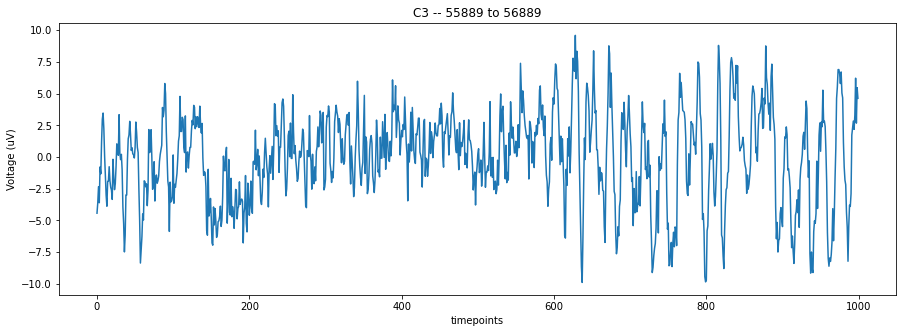

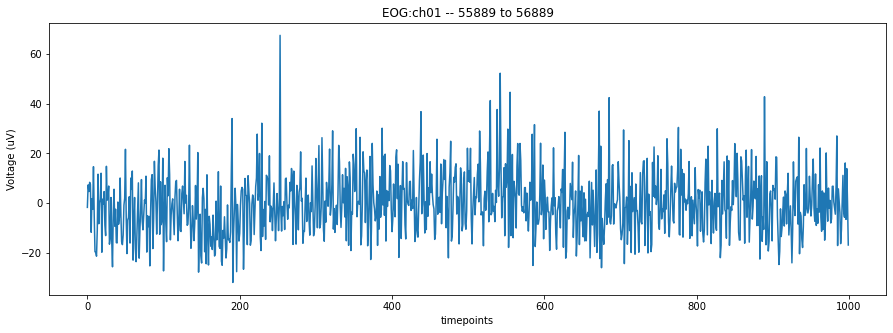

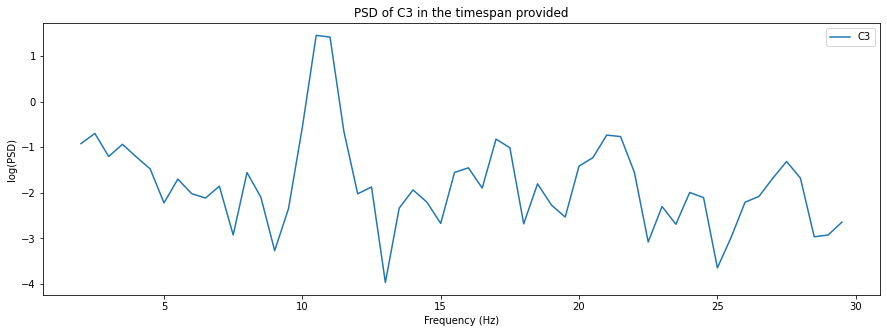

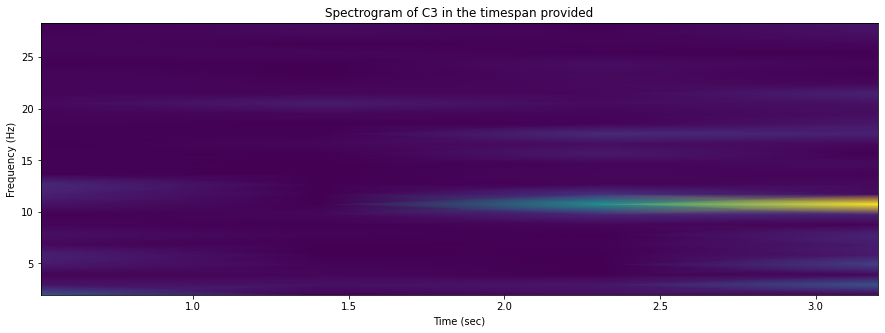

In [27]:
# Try adjust these variables to see different time ranges! 
# A single trial is 4 seconds or 1000 timpoints (4 ms per timepoint)
# Hint: refer to the Epoched data dataframe for the time of each trial
start_time_ms = 223556 # Start time in millis
start_time_timepoints = start_time_ms // 4 # Divide by 4 to get into timepoints
end_time_timepoints = start_time_timepoints + 1000 # Specify number of more timepoints we want past start

# Plot a single EEG channel
plt.figure(figsize=(15,5))
plt.plot(eeg_df['C3'].values[start_time_timepoints:end_time_timepoints])
plt.title("C3 -- " + str(start_time_timepoints) + " to " + str(end_time_timepoints))
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()

# Plot a single EOG channel
plt.figure(figsize=(15,5))
plt.plot(eeg_df['EOG:ch01'].values[start_time_timepoints:end_time_timepoints])
plt.title("EOG:ch01 -- " + str(start_time_timepoints) + " to " + str(end_time_timepoints))
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()

# Plot the PSD of the single EEG channel
plt.figure(figsize=(15,5))
plotPSD_fromEEG(eeg_df['C3'].values[start_time_timepoints:end_time_timepoints], pre_cut_off_freq=2, post_cut_off_freq=30,label="C3")
plt.title("PSD of C3 in the timespan provided")
plt.legend()
plt.show()

# Plot the spectrogram of the single EEG channel
plt.figure(figsize=(15,5))
plotSpectrogram_fromEEG(eeg_df['C3'].values[start_time_timepoints:end_time_timepoints], pre_cut_off_freq=2, post_cut_off_freq=30)
plt.title("Spectrogram of C3 in the timespan provided")
plt.show()

In [32]:
# Try epoching at different lengths! (4000ms is default by experiment setup)
eeg_epoch_df = getEpochedDF(eeg_df, event_df, trial_duration_ms=4000) 

# Preview dataframe of trials
# start_time denotes the ms since the start of the recording when this trial or epoch started.
eeg_epoch_df.head() #1000 in each channel -> 4s of data in each row (one trial)

,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948729, 6.485084306095979, 6.68955...","[7.354848554207675, 4.699778744182498, 8.39246...","[5.676356145571069, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,232996.0,1,"[2.948043030441749, -0.0549324788281071, 0.381...","[4.43732356755932, 2.4872205691615163, 0.96742...","[1.385519188220035, -0.4699778744182498, 0.442...","[-18.12771801327535, 18.18875410086213, -5.828...","[-14.373998626688028, 21.48470283054856, -6.25...","[-11.932555123216602, 20.202944991226055, -9.6..."
2,251268.0,0,"[-0.2380407415884641, -2.072175173571374, -2.5...","[2.825970855268177, 3.308155947203784, 1.83718...","[-0.9155413138017852, -0.5645838101777675, -2....","[-8.331425955596247, -15.7778286411841, -1.922...","[-1.9226367589837492, -9.552147707331958, -6.6...","[-8.453498130769818, -15.228503852903028, -7.1..."
3,259416.0,1,"[-0.5554283970397498, -2.926680399786373, -4.9...","[5.743495841916532, 4.785229266803998, 3.40581...","[0.9155413138017852, 1.541161211566339, 1.0284...","[6.622415503166247, 3.11284046692607, 11.74944...","[-1.6174563210498203, -2.349889372091249, 9.00...","[-2.227817196917677, 2.349889372091249, 12.909..."
4,294924.0,1,"[-2.8961623559929808, -2.352941176470588, -1.7...","[2.844281681544213, 2.7557793545433737, 2.0752...","[-0.8331425955596247, -0.3234912642099641, 0.6...","[7.2938124666208894, -2.655069810025177, 7.110...","[7.934691386282138, 0.183108262760357, 12.9396...","[14.740215152208744, 6.317235065232318, 15.472..."


In [45]:
# We've already epoched all the data into 4000ms trials for you in epoched_train.pkl and epoched_test.pkl :) 
# These are the epochs that will be used in accuracy evaluation
epoch_df_filename = Path("../dataset_neural_analysis/data/epoched_train.pkl")
eeg_epoch_full_df = pd.read_pickle(epoch_df_filename)
eeg_epoch_full_df.head()

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."
2,B0101T,251268.0,0,"[-0.2380407415884641, -2.0721751735713743, -2....","[2.825970855268177, 3.308155947203784, 1.83718...","[-0.9155413138017852, -0.5645838101777675, -2....","[-8.331425955596247, -15.7778286411841, -1.922...","[-1.9226367589837492, -9.552147707331956, -6.6...","[-8.453498130769818, -15.228503852903028, -7.1..."
3,B0101T,259416.0,1,"[-0.5554283970397498, -2.926680399786373, -4.9...","[5.743495841916532, 4.785229266803998, 3.40581...","[0.9155413138017852, 1.541161211566339, 1.0284...","[6.6224155031662475, 3.1128404669260696, 11.74...","[-1.6174563210498203, -2.349889372091249, 9.00...","[-2.2278171969176768, 2.349889372091249, 12.90..."
4,B0101T,294924.0,1,"[-2.8961623559929808, -2.352941176470588, -1.7...","[2.8442816815442127, 2.7557793545433737, 2.075...","[-0.8331425955596247, -0.32349126420996416, 0....","[7.2938124666208894, -2.655069810025177, 7.110...","[7.934691386282138, 0.18310826276035705, 12.93...","[14.740215152208743, 6.3172350652323175, 15.47..."


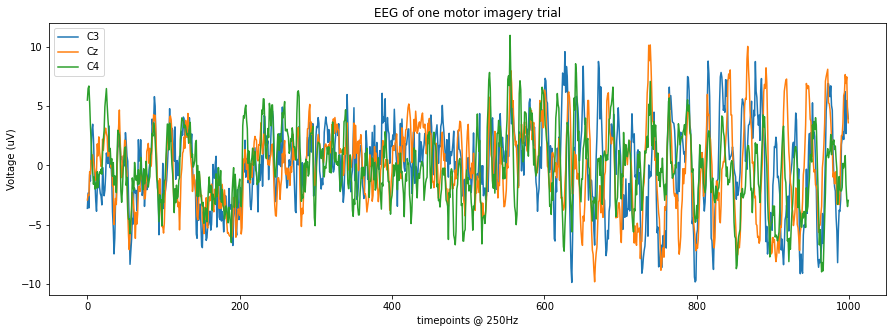

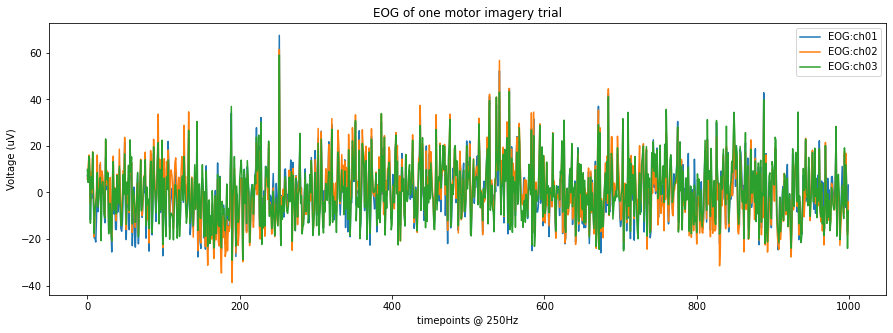

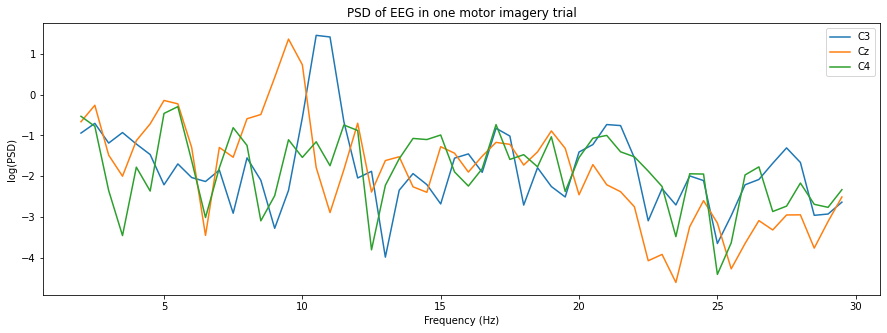

In [57]:
# Visualize EEG and PSD for one trial
# Try changing trial_num to view different trials!
trial_num = 0

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plt.plot(eeg_epoch_full_df[ch][trial_num], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EEG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eog_chans: 
    plt.plot(eeg_epoch_full_df[ch][trial_num], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EOG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plotPSD_fromEEG(eeg_epoch_full_df[ch][trial_num], pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)
plt.title("PSD of EEG in one motor imagery trial")
plt.legend()
plt.show()

In [58]:
# Get PSD averages for each channel for each event type (0=left or 1=right)
psd_averages_by_type = {}

for event_type in event_types.keys(): 
    psds_only_one_type={}
    freqs_only_one_type={}
    for i, row in eeg_epoch_full_df[eeg_epoch_full_df["event_type"] == event_type].iterrows(): 
        for ch in eeg_chans: 
            if ch not in psds_only_one_type: 
                psds_only_one_type[ch] = list()
                freqs_only_one_type[ch] = list()
            f, p = getMeanFreqPSD(row[ch])
            psds_only_one_type[ch].append(p)
            freqs_only_one_type[ch].append(f)
    avg_psds_one_type = {}
    for ch in eeg_chans:
        psds_only_one_type[ch] = np.array(psds_only_one_type[ch])
        avg_psds_one_type[ch] = np.mean(psds_only_one_type[ch], axis=0)
    psd_averages_by_type[event_type] = dict(avg_psds_one_type)

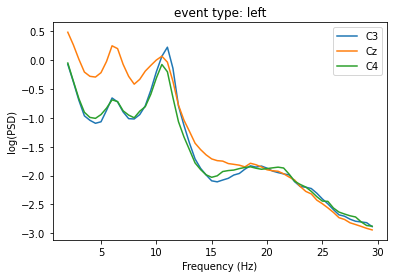

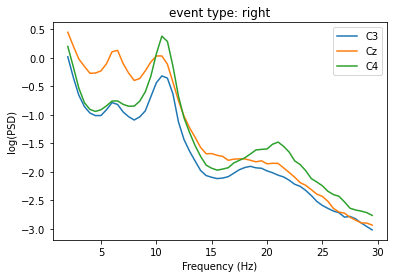

In [59]:
# View Average PSDs
for event_type in event_types.keys(): 
    for ch in eeg_chans[:]: 
        plotPSD(freqs_only_one_type[eeg_chans[0]][0], psd_averages_by_type[event_type][ch],pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)

    plt.legend()
    plt.title("event type: " + event_types[event_type])
    plt.show()

In [60]:
print('C3: ' + str(eeg_df['C3'].mean()) + " uV")
print('Cz: ' + str(eeg_df['Cz'].mean()) + " uV")
print('C4: ' + str(eeg_df['C4'].mean()) + " uV")

C3: -0.10846607963398974 uV
Cz: -0.11128156713907804 uV
C4: -0.11054305230804819 uV


In [61]:
print('C3: ' + str(eeg_df['C3'].std()) + " uV")
print('Cz: ' + str(eeg_df['Cz'].std()) + " uV")
print('C4: ' + str(eeg_df['C4'].std()) + " uV")

C3: 5.604447873267396 uV
Cz: 4.856616019325371 uV
C4: 5.7806750957231685 uV


In [64]:
print('C3: ' + str(max(eeg_df['C3']) - min(eeg_df['C3'])) + " uV")
print('Cz: ' + str(max(eeg_df['Cz']) - min(eeg_df['Cz'])) + " uV")
print('C4: ' + str(max(eeg_df['C4']) - min(eeg_df['C4'])) + " uV")

C3: 155.58403906309607 uV
Cz: 121.8860151064317 uV
C4: 149.36140993362326 uV
